In [1]:
11

11

In [2]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict,Literal,Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage,HumanMessage

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
genarater_llm=ChatGroq(model="gemma2-9b-it")
evaluvater_llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
optimizer_llm=ChatGroq(model="qwen/qwen3-32b")


In [9]:

from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [10]:
structer_evaluvater_llm=evaluvater_llm.with_structured_output(TweetEvaluation)

In [4]:
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluacion:Literal["approved","need_improve"]
    feedback:str
    iteration:int
    max_iteration:int

In [5]:
def genarate(state:TweetState):
     messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
     responce=genarater_llm.invoke(messages).content
     return {'tweet':responce}

In [11]:
def evaluatetweet(state:TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    responce=structer_evaluvater_llm.invoke(messages)
    return{'evaluacion':responce.evaluation,'feedback':responce.feedback}

In [15]:
def optimize(state:TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    responce=optimizer_llm.invoke(messages).content
    iteration=state['iteration'] + 1
    return{'tweet':responce,'iteration':iteration}
       



In [17]:
def route(state:TweetState):
    if state['evaluacion'] == 'approved' or state['max_iteration']<=state['iteration']:
        return 'approved'
    else:
        return 'need_improve'

In [18]:
graph=StateGraph(TweetState)
graph.add_node('genarate',genarate)
graph.add_node('evaluate',evaluatetweet)
graph.add_node('optimize',optimize)

graph.add_edge(START,'genarate')
graph.add_edge('genarate','evaluate')
graph.add_conditional_edges('evaluate',route,{'approved':END,'need_improve':'optimize'})
graph.add_edge('optimize','evaluate')
workflow=graph.compile()

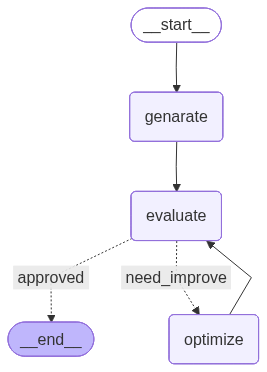

In [19]:
workflow

In [21]:
initial_state={
    'topic':'AI',
    'iteration':1,
    'max_iteration':5
}

In [23]:
workflow.invoke(initial_state)

{'topic': 'AI',
 'tweet': "Just saw an AI write a poem about existential dread.  Now I'm worried the robots are gonna start *feeling* things. Like, can I get a refund on humanity if it's now sentient and emo?  😭🤖  #AIWoes  #RobotDrama  \n",
 'evaluacion': 'approved',
 'feedback': 'This tweet is original, humorous, and punchy. It cleverly combines the fear of AI with a relatable human emotion, making it engaging and shareable. The use of emojis and hashtags adds to its appeal without feeling forced. The only minor improvement could be to make the humor slightly more unexpected to enhance virality.',
 'iteration': 1,
 'max_iteration': 5}